In [1]:
import meep as mp

In [2]:
cell = mp.Vector3(16, 16, 0)
geomtery = [mp.Block(mp.Vector3(12, 1, mp.inf), 
                    center = mp.Vector3(-2.5, -3.5),
                    material=mp.Medium(epsilon=12)),
           mp.Block(mp.Vector3(1, 12, mp.inf),
                   center = mp.Vector3(3.5, 2), 
                   material = mp.Medium(epsilon=30))]
pml_layers = [mp.PML(1.0)]
resolution = 10

In [3]:
source = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                   component=mp.Ez,
                   center=mp.Vector3(-7, -3.5),
                   size=mp.Vector3(0, 1))]


In [4]:
sim = mp.Simulation(cell_size=cell, 
                   boundary_layers = pml_layers,
                   geometry=geomtery,
                   sources=source,
                   resolution=resolution)
sim.run(mp.at_beginning(mp.output_epsilon), 
       mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
       until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 9.91821e-05 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (30,30,30)
time for set_epsilon = 0.0335929 s
-----------
creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


In [6]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
ez_data.shape

(160, 160)

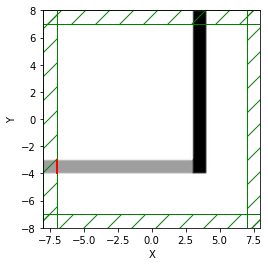

In [5]:
sim.plot2D()

creating output file "./eps-000200.00.h5"...
run 1 finished at t = 400.0 (8000 timesteps)


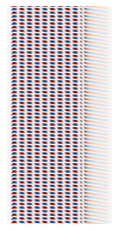

In [6]:
vals = []
def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0, -3.5), size=mp.Vector3(16, 0), component=mp.Ez))
    
sim.run(mp.at_beginning(mp.output_epsilon), 
       mp.at_every(0.6, get_slice),
       until=200)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(vals, interpolation='spline36', cmap='RdBu')
plt.axis('off')
plt.show()

In [7]:
from __future__ import division

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10 # pixels/um

In [8]:
sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)

In [9]:
dpml = 1.0
pml_layers = [mp.PML(dpml)]

pad = 4  # padding distance between waveguide and cell edge
w = 1    # width of waveguide

wvg_xcen =  0.5*(sx-w-2*pad)  # x center of vert. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of horiz. wvg

geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=mp.Medium(epsilon=12))]

fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

-----------
Initializing structure...
time for choose_chunkdivision = 8.08239e-05 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0545499 s
-----------


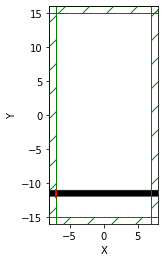

In [10]:
sim.plot2D()

In [11]:
nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0),size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen,df,nfreq,refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0),size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen,df,nfreq,tran_fr)

pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

field decay(t = 50.050000000000004): 4.825189380557793e-09 / 4.825189380557793e-09 = 1.0
field decay(t = 100.05000000000001): 0.028801809879425856 / 0.028801809879425856 = 1.0
field decay(t = 150.1): 0.026893465093385728 / 0.028801809879425856 = 0.9337421921042772
field decay(t = 200.15): 2.315839733669588e-13 / 0.028801809879425856 = 8.040604890333206e-12
run 0 finished at t = 200.15 (4003 timesteps)


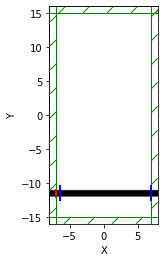

In [12]:
sim.plot2D()

In [13]:
# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf),center=mp.Vector3(-0.5*pad,wvg_ycen),material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf),center=mp.Vector3(wvg_xcen,0.5*pad),material=mp.Medium(epsilon=12))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0),size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen,df,nfreq,tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl,straight_refl_data)

pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 7.39098e-05 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.063102 s
-----------
field decay(t = 50.050000000000004): 1.6976522694449004e-10 / 1.6976522694449004e-10 = 1.0
field decay(t = 100.05000000000001): 4.691071063910547e-07 / 4.691071063910547e-07 = 1.0
field decay(t = 150.1): 2.992872733686027e-07 / 4.691071063910547e-07 = 0.6379934758846145
field decay(t = 200.15): 0.003927813565272278 / 0.003927813565272278 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939073963 / 0.003927813565272278 = 0.03821230740627967
field decay(t = 3

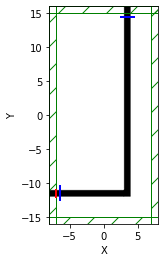

In [14]:
sim.plot2D()

In [15]:
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

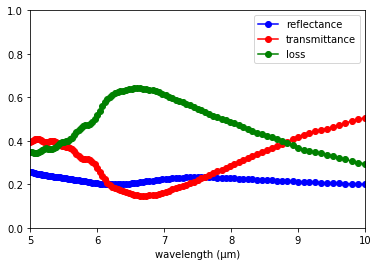

In [16]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])

if mp.am_master():
    plt.figure()
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

In [18]:
import meep as mp
import argparse
import math

def main(args):
    resolution = args.res

    dpml = 1.0                      # PML thickness
    sz = 10                         # size of computational cell (without PMLs)
    sz = 10 + 2*dpml
    cell_size = mp.Vector3(0,0,sz)
    pml_layers = [mp.PML(dpml)]

    wvl_min = 0.4                   # min wavelength
    wvl_max = 0.8                   # max wavelength
    fmin = 1/wvl_max                # min frequency
    fmax = 1/wvl_min                # max frequency
    fcen = 0.5*(fmin+fmax)          # center frequency
    df = fmax-fmin                  # frequency width
    nfreq = 50                      # number of frequency bins
    
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(args.theta)

    # plane of incidence is XZ
    k = mp.Vector3(math.sin(theta_r),0,math.cos(theta_r)).scale(fmin)
    
    # if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3
    
    sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, center=mp.Vector3(0,0,-0.5*sz+dpml))]

    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        dimensions=dimensions,
                        resolution=resolution)

    refl_fr = mp.FluxRegion(center=mp.Vector3(0,0,-0.25*sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(0,0,-0.5*sz+dpml), 1e-9))

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)
    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,0.5*sz), center=mp.Vector3(0,0,0.25*sz), material=mp.Medium(index=3.5))]

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k,
                        dimensions=dimensions,
                        resolution=resolution)

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(0,0,-0.5*sz+dpml), 1e-9))

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    for i in range(nfreq):
        print("refl:, {}, {}, {}, {}".format(k.x,1/freqs[i],math.degrees(math.asin(k.x/freqs[i])),-refl_flux[i]/empty_flux[i]))
    
#if __name__ == '__main__':
parser = argparse.ArgumentParser()
parser.add_argument('-res', type=int, default=200, help='resolution (default: 200 pixels/um)')
parser.add_argument('-theta', type=float, default=0, help='angle of incident planewave (default: 0 degrees)')
args = parser.parse_args()
main(args)


usage: ipykernel_launcher.py [-h] [-res RES] [-theta THETA]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/peter/.local/share/jupyter/runtime/kernel-666420db-9239-4fad-907a-1e4a1e633d04.json


SystemExit: 2